## Experiment: Hamiltonian discrimination using SPSA
Experiment (Fig. 4): distinguish the random thermal state sampled from the Hamiltonian $H=X_1X_2+ Z_1+Z_2$ with either a positive or negative coefficient of $X_1 X_2$.

In [1]:
import torch
import time
import numpy as np
from typing import Tuple

import quairkit as qkit
from quairkit import Hamiltonian, to_state, Circuit
from quairkit.loss import Measure
from quairkit.database import *
from quairkit.qinfo import *

import os

qkit.set_dtype('complex128')

In [2]:
import numpy as np
import quairkit as qkit

from algorithm import algorithm1

Plot setting

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({
    "font.family": "STIXGeneral",
    "mathtext.fontset": "cm",
})

Experiment setting

In [4]:
h = torch.tensor([1, 1, 1])
# hamiltonian = Hamiltonian([(h[0], 'X0, X1'), (h[1], 'Y0, Y1'), (h[2], 'Z0, Z1')])
hamiltonian = Hamiltonian([(h[0], 'Z0'), (h[1], 'Z1'), (h[2], 'X0, X1')])
n = 2

lb, si, sites = hamiltonian.decompose_with_sites()
xi = sum(abs(coef) for coef in lb)
beta = 5
error_level = 1.5
error = 10 ** (-error_level)

num_step = int(np.ceil((xi ** 2) * (beta ** 2) / (error ** (2 / 3))))
print(num_step)

2250


Create Logger for record

In [5]:
import logging
from contextlib import redirect_stdout, redirect_stderr

class StreamToLogger:
    """File-like object that sends writes to a logger (line-buffered)."""
    def __init__(self, logger, level=logging.INFO):
        self.logger = logger
        self.level = level
        self._buf = ""

    def write(self, msg: str):
        # Many libs call .write() in chunks; buffer until newline.
        self._buf += msg
        while "\n" in self._buf:
            line, self._buf = self._buf.split("\n", 1)
            if line := line.rstrip("\r"):
                self.logger.log(self.level, line)

    def flush(self):
        if leftover := self._buf.strip("\r\n"):
            self.logger.log(self.level, leftover)
        self._buf = ""

def make_logger(log_file: str = "run.log") -> logging.Logger:
    logger = logging.getLogger("captured_prints")
    logger.setLevel(logging.INFO)
    logger.propagate = False
    logger.handlers.clear()  # avoid duplicate handlers on re-runs (e.g., notebooks)

    # mode="w" => overwrite/clean old log each run
    fh = logging.FileHandler(log_file, mode="w", encoding="utf-8")
    fh.setFormatter(logging.Formatter("%(asctime)s %(levelname)s %(message)s"))
    logger.addHandler(fh)
    return logger

logger = make_logger("run.log")  # saved in *current working directory*
out = StreamToLogger(logger, logging.INFO)
err = StreamToLogger(logger, logging.ERROR)

Create sample functions

In [6]:
pauli_dict = {
    'I': eye(),
    'X': x(),
    'Y': y(),
    'Z': z(),
}
def pauli_str_to_matrix(pauli_str: str) -> torch.Tensor:
    matrices = []
    for i in range(n):
        if pauli_str[i] == 'X':
            matrices.append(pauli_dict['X'])
        elif pauli_str[i] == 'Y':
            matrices.append(pauli_dict['Y'])
        elif pauli_str[i] == 'Z':
            matrices.append(pauli_dict['Z'])
        elif pauli_str[i] == 'I':
            matrices.append(pauli_dict['I'])
        else:
            raise ValueError(f"Invalid pauli string: {pauli_str}")
    return nkron(*matrices)

list_pauli_str = hamiltonian.pauli_words
list_pauli_matrix = torch.stack([pauli_str_to_matrix(p_str) for p_str in list_pauli_str])

def coef_to_gibbs(coef: np.ndarray) -> torch.Tensor:
    coef = torch.from_numpy(coef).unsqueeze(-1).unsqueeze(-1)
    matrix = torch.sum(coef * list_pauli_matrix, dim=-3)
    rho = torch.matrix_exp(-beta * matrix)
    return rho / trace(rho).view([-1, 1, 1])

In [7]:
num_sampler_per_itr = 1000
barrier = 0.01

def coef_weight(filter_coef: torch.Tensor) -> torch.Tensor:
    w_min = 0.05
    w = torch.sigmoid((torch.abs(filter_coef) - barrier * xi) / (0.25 * barrier * xi))
    return w_min + (1.0 - w_min) * w
    

def get_train_sample() -> Tuple[qkit.State, torch.Tensor, torch.Tensor]:
    r"""Sample num_sampler_per_itr states such that |coef| for ZZ >= barrier * xi
    
    Args:
        sample_size: number of states to sample. If None, use num_sampler_per_itr
        test: whether in test mode. If True, the sampled states are generated precisely without using algorithm1.
    
    Returns:
        sampled states, their 0, 1 labels and their weight
    """
    sample_size = num_sampler_per_itr

    list_sampled_state = []
    list_label = []
    list_weight = []
    sample_ratio = 2
    num_sampled_state = 0
    with redirect_stdout(out), redirect_stderr(err):
        while num_sampled_state < sample_size:
            remain_num = min(50000, max(10, (sample_size - num_sampled_state) * sample_ratio))
            print(f"Sampling {remain_num} states...")
            
            list_state, sample_coef, _, _ = algorithm1(
                n=n,
                beta=beta,
                hamiltonian=hamiltonian,
                error=error,
                num_sample=remain_num,
                num_step=num_step,
                save_state=False,
                save_compressed=False,
            )
            
            sample_coef = torch.from_numpy(sample_coef)
            satisfy_barrier = torch.abs(sample_coef)[:, -1] >= barrier * xi
            
            list_sampled_state.append(list_state[satisfy_barrier].density_matrix)
            list_label.append(torch.sign(sample_coef[satisfy_barrier, -1]))
            list_weight.append(coef_weight(sample_coef[satisfy_barrier, -1]))
            
            num_sampled_state += torch.sum(satisfy_barrier).item()
            sample_ratio *= 2
        
    sampled_state = to_state(torch.cat(list_sampled_state, dim=0)[:sample_size])
    sampled_label = torch.cat(list_label, dim=0)[:sample_size]
    sampled_weight = torch.cat(list_weight, dim=0)[:sample_size]
    return sampled_state, sampled_label, sampled_weight

In [8]:
def get_test_sample(sample_size: int) -> Tuple[qkit.State, torch.Tensor, torch.Tensor]:
    a_row = h.view(1, len(h))

    # acceptance rate = 1 - y^L (use it to pick a reasonable batch size)
    acc = 1.0 - (barrier ** len(h))
    batch = max(1024, int((sample_size / max(acc, 1e-6)) * 1.2))

    list_coef = []
    i = 0
    while i < sample_size:
        u = torch.rand((batch, len(h)))
        x = (u * 2 - 1) * a_row                      # uniform in outer box
        keep = (x.abs() >= (a_row * barrier)).any(dim=1)   # outside inner box
        x = x[keep]
        list_coef.append(x)
        i += x.size(0)
        batch = max(1024, sample_size - i)  # adjust a bit as we get close

    sample_coef = torch.cat(list_coef, dim=0)[:sample_size]
    sampled_state = to_state(coef_to_gibbs(sample_coef.numpy()))
    sampled_label = torch.sign(sample_coef[:, -1])
    sampled_weight = coef_weight(sample_coef[:, -1])
    return sampled_state, sampled_label, sampled_weight



Iteration setting

In [9]:
num_repeat = 2
NUM_ITR = 100
shift_coef = 0.5
LR = 0.1
losses, fidelities = [], []
for iter_ter in range(num_repeat):
    print(f"Run {iter_ter + 1}")
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    seed = np.random.randint(1, 10000)
    qkit.set_seed(seed)
    qkit.get_seed()
    test_state, test_label, _ = get_test_sample(num_sampler_per_itr * 3)
    print('barrier', barrier * xi)
    print(test_state.shape)
    print(test_label.shape)
    rho = test_state.density_matrix
    D = trace_distance(rho[test_label > 0].mean(dim=0), rho[test_label < 0].mean(dim=0)).item()
    P_succ_helstrom = 0.5 * (1.0 + D)
    print("Helstrom optimal success prob =", P_succ_helstrom)
    
    cir = Circuit(3)
    cir.ry([1, 2])
    cir.cnot([[1, 0], [2, 0]])

    num_param = len(cir.param)
    op = Measure()
    ancilla_state = zero_state(1)

    def loss_fcn(circuit: Circuit) -> torch.Tensor:
        train_state, train_label, train_weight = get_train_sample()
        input_state = ancilla_state.kron(train_state)
        output_state = circuit(input_state)
        # predict_label = 1 - 2 * torch.multinomial(op(output_state, 0), num_samples=1).squeeze(1) ## for ZZ, where 0 -> +1, 1 -> -1
        predict_label = 2 * torch.multinomial(op(output_state, 0), num_samples=1).squeeze(1) - 1  ## for XX, where 0 -> -1, 1 -> +1
        return ((1 - predict_label * train_label) * train_weight).sum() / train_weight.sum() / 2

    @torch.no_grad()
    def eval_loss_at(theta_vec: torch.Tensor) -> torch.Tensor:
        cir.update_param(theta_vec.detach())
        return loss_fcn(cir)

    def fidelity_fcn(circuit: Circuit) -> torch.Tensor:
        input_state = ancilla_state.kron(test_state)
        output_state = circuit(input_state)
        prob = op(output_state, 0)
        # return (prob[test_label > 0, 0].mean() + prob[test_label < 0, 1].mean()) / 2 ## for ZZ
        return (prob[test_label < 0, 0].mean() + prob[test_label > 0, 1].mean()) / 2 ## for XX
    

    loss_list, fidelity_list, time_list = [], [], []

    theta = torch.nn.Parameter(cir.param.detach().clone())
    opt = torch.optim.Adam([theta], lr=LR, betas=(0.9, 0.999), eps=1e-8)

    for itr in range(NUM_ITR):
        start_time = time.time()
        with torch.no_grad():
            cir.update_param(theta.detach())
        delta = (2 * torch.randint(0, 2, theta.shape) - 1)

        ck = shift_coef

        R_plus  = eval_loss_at(theta + ck * delta)
        loss = eval_loss_at(theta)
        R_minus = eval_loss_at(theta - ck * delta)

        grad_est = ((R_plus - R_minus) / (2 * ck)) * delta

        opt.zero_grad(set_to_none=True)
        theta.grad = grad_est.detach()
        opt.step()

        loss_list.append(loss.item())
        time_list.append(time.time() - start_time)

        fidelity = fidelity_fcn(cir).item() # compute fidelity
        fidelity_list.append(fidelity)
        print(f"iter: {str(itr).zfill(len(str(NUM_ITR)))}, " +
            f"loss: {loss:.6f}, fidelity: {fidelity:.6f}, " +
            f"avg_time: {np.mean(time_list):.4f}s")
        time_list = []
    losses.append(loss_list)
    fidelities.append(fidelity_list)
    print('The idea upper bound of success prob:', P_succ_helstrom)

Run 1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
barrier 0.03
torch.Size([3000, 4, 4])
torch.Size([3000])
Helstrom optimal success prob = 0.7325277235530008
iter: 000, loss: 0.488069, fidelity: 0.624488, avg_time: 20.8987s
iter: 001, loss: 0.448443, fidelity: 0.557675, avg_time: 20.5832s
iter: 002, loss: 0.446219, fidelity: 0.488908, avg_time: 20.5812s
iter: 003, loss: 0.454640, fidelity: 0.495571, avg_time: 20.5698s
iter: 004, loss: 0.444371, fidelity: 0.504490, avg_time: 20.5920s
iter: 005, loss: 0.419645, fidelity: 0.615621, avg_time: 20.6601s
iter: 006, loss: 0.370404, fidelity: 0.529485, avg_time: 20.7097s
iter: 007, loss: 0.431789, fidelity: 0.641679, avg_time: 20.6058s
iter: 008, loss: 0.418696, fidelity: 0.650402, avg_time: 20.6225s
iter: 009, loss: 0.405119, fidelity: 0.727142, avg_time: 20.6614s
iter: 010, loss: 0.388490, fidelity: 0.665000, avg_time: 20.5798s
iter: 011, loss: 0.385758, fidelity: 0.670284, avg_time: 20.5849s
iter: 012, loss: 0.406494, fidelity: 0.617690, avg_

Save data

In [ ]:
np.savez("data/spsa_exp_results.npz",
        losses=losses,
        fidelities=fidelities,
    )

Clear logs

In [11]:
out.flush()
err.flush()
for h in logger.handlers:
    h.flush()

We also provide saved data to save computation time.

In [ ]:
file_path = "data/spsa_exp_results.npz"
out_pdf = "accuracy_prl_figure.pdf"
out_png = "accuracy_prl_figure.png"
data = np.load(file_path)

fidelities = data['fidelities']

Plot

Saved accuracy_prl_figure.pdf and accuracy_prl_figure.png


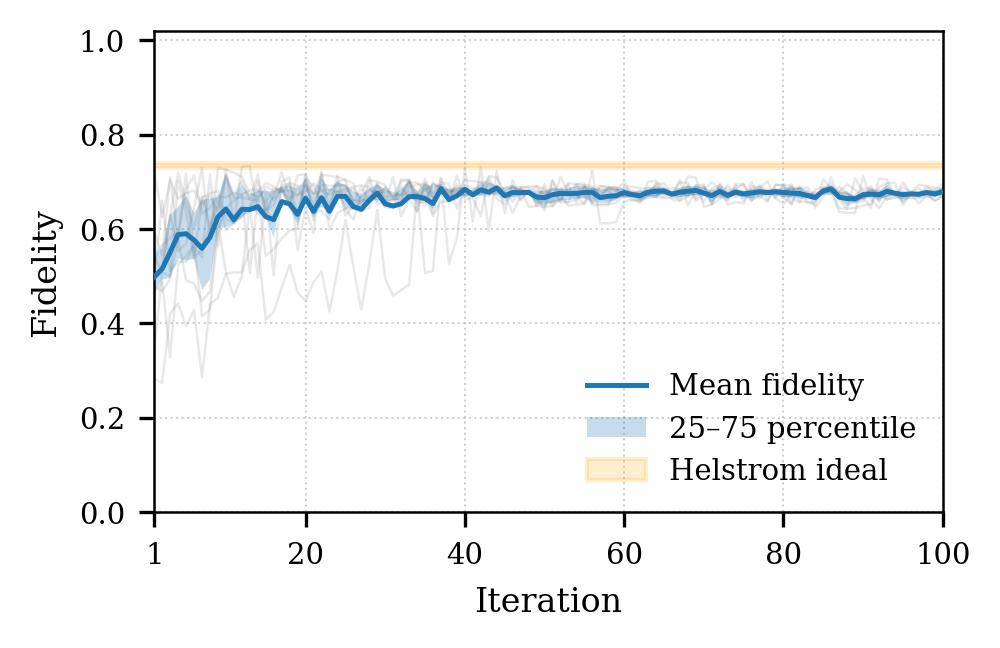

In [ ]:
pct_low, pct_high = 25, 75

fig_w, fig_h = 3.375, 2.2

data = np.load(file_path)

fidelities = data['fidelities']
n_runs, n_iters = fidelities.shape
x = np.arange(1, n_iters + 1)

fid_mean = fidelities.mean(axis=0)
fid_p_low = np.percentile(fidelities, pct_low, axis=0)
fid_p_high = np.percentile(fidelities, pct_high, axis=0)

plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Times', 'DejaVu Serif'],
    'font.size': 8,
    'axes.titlesize': 9,
    'axes.labelsize': 8,
    'legend.fontsize': 7,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'figure.dpi': 300,
    'axes.linewidth': 0.6,
    'lines.linewidth': 1.0,
})

fig, ax = plt.subplots(figsize=(fig_w, fig_h))
for i in range(n_runs):
    ax.plot(x, fidelities[i], color='gray', linewidth=0.6, alpha=0.18, zorder=1)

ax.plot(x, fid_mean, label='Mean fidelity', linewidth=1.2, zorder=3)
ax.fill_between(x, fid_p_low, fid_p_high, alpha=0.25, label=f'{pct_low}–{pct_high} percentile', zorder=2)

helstrom_lower, helstrom_upper = 0.73, 0.74
ax.axhspan(helstrom_lower, helstrom_upper, color='orange', alpha=0.18,
           label='Helstrom ideal', zorder=0)

ax.set_xlabel('Iteration')
ax.set_ylabel('Fidelity')
ax.set_xlim(1, n_iters)
ax.set_ylim(0.0, 1.02)

ax.set_xticks([1, 20, 40, 60, 80, n_iters])
ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.6)
ax.legend(loc='lower right', frameon=False)

plt.tight_layout()

# fig.savefig(out_pdf, bbox_inches='tight', pad_inches=0.02)
# fig.savefig(out_png, dpi=300, bbox_inches='tight', pad_inches=0.02)
print(f"Saved {out_pdf} and {out_png}")
plt.show()

In [6]:
qkit.print_info()


---------VERSION---------
quairkit: 0.4.3
torch: 2.6.0
torch cuda: 12.6
numpy: 2.3.5
scipy: 1.16.3
matplotlib: 3.10.7
---------SYSTEM---------
Python version: 3.11.14
OS: Linux
OS version: #17~24.04.2-Ubuntu SMP PREEMPT_DYNAMIC Mon Jan 20 22:48:29 UTC 2
---------DEVICE---------
CPU:  Intel(R) Core(TM) i9-14900K
GPU: (0) NVIDIA GeForce RTX 4090
